# import

In [374]:
# %pip install catboost
# %pip install shap
# %pip install optuna

In [375]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, root_mean_squared_error, f1_score
import shap
import optuna
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import KFold

In [376]:
# %unzip train_dataset_soc_dem_train.zip

In [377]:
train_events, y = pd.read_csv('train_events.csv'), pd.read_csv('train_targets.csv')

In [378]:
video_info = pd.read_csv('video_info_v2.csv')

In [379]:
all = pd.read_csv('all_events.csv')

In [380]:
dop_info = pd.read_csv('video_info.csv')

In [381]:
to_test = pd.read_csv('test_events.csv')

In [382]:
test = pd.DataFrame(to_test['viewer_uid'].unique(), columns=['viewer_uid'])

# features in train

In [383]:
os_replacer = {'Android' : 'Android', 'Windows' : 'Windows',
               'nan' : "NO INFO", 'Mac' : 'MacOS',
               'iOS' : 'IOS', 'GNU/Linux' : 'Linux',
               'iPadOS' : 'iPadOS', 'Ubuntu' : 'Linux',
               'Windows Phone' : 'Windows',
               'android tv' : 'TV',
               'Fire OS' : 'Android', 'MeeGo' : 'Linux',
               'BlackBerry OS' : 'BB', 'Windows CE' : 'Windows',
               'BlackBerry Tablet OS' : 'BB', 'HarmonyOS' : 'Phone',
               'KaiOS' : 'Linux', 'Symbian' : 'Phone',
               'MocorDroid' : 'Android', 'Windows RT' : 'Windows',
               'Symbian OS Series 60' : 'Phone', 'Chrome OS' : 'Linux',
               'Debian' : 'Linux', 'OpenBSD' : 'Linux',
               'SUSE' : 'Linux', 'CentOS' : 'Linux',
               'Fedora' : 'Linux', 'NetBSD' : 'Linux',
               'wear os' : 'Phone'}

browsers = {
    'Rutube' : 'Rutube', 'Yandex Browser' : 'Yandex Browser',
    'Chrome' : 'Chrome', 'Chrome Mobile' : 'Chrome Mobile',
    'Mobile Safari' : 'Mobile Safari', 'Safari' : 'Safari',
    'Microsoft Edge' : 'Microsoft Edge', 'Firefox Mobile' : 'Firefox Mobile',
    'Opera' : 'Opera', 'Firefox' : 'Firefox', 'Chrome Mobile iOS' : 'Chrome Mobile iOS',
    'Samsung Browser': 'мобильный',
    'Google Search App': 'мобильный',
    'Android Browser': 'мобильный',
    'Opera Mobile': 'мобильный',
    'Chrome Webview': 'мобильный',
    'Huawei Browser Mobile': 'мобильный',
    'Opera Mini': 'мобильный',
    'MIUI Browser': 'мобильный',
    'IE Mobile': 'мобильный',
    'Mobile Silk': 'мобильный',
    'DuckDuckGo Privacy Browser': 'мобильный',
    'Firefox Mobile iOS': 'мобильный',
    'WeChat': 'мобильный',
    'vivo Browser': 'мобильный',
    'Facebook': 'мобильный',
    'Smart Lenovo Browser': 'мобильный',
    'HeyTapBrowser': 'мобильный',
    'Stargon': 'мобильный',
    'QQ Browser': 'мобильный',
    'Mint Browser': 'мобильный',
    'BlackBerry Browser': 'мобильный',
    'Nokia Browser': 'мобильный',

    'Internet Explorer': 'десктопный',
    'Opera GX': 'десктопный',
    'Iron': 'десктопный',
    'RDDocuments': 'десктопный',
    'AdBlock Browser': 'десктопный',
    'Avast Secure Browser': 'десктопный',
    'SberBrowser': 'десктопный',
    'Microsoft Bing Search': 'десктопный',
    'Firefox Focus': 'десктопный',
    'CoolBrowser': 'десктопный',
    'UC Browser': 'десктопный',
    'Aloha Browser': 'десктопный',
    'AVG Secure Browser': 'десктопный',
    'Soul Browser': 'десктопный',
    'Chromium': 'десктопный',
    'Chromium GOST': 'десктопный',
    'QtWebEngine': 'десктопный',
    '360 Secure Browser': 'десктопный',
    'Vivaldi': 'десктопный',
    'Ecosia': 'десктопный',
    'Whale Browser': 'десктопный',
    'Hi Browser': 'десктопный',
    'Chrome Frame': 'десктопный'
}

In [384]:
region_dict = {
    'Chelyabinsk': 'Челябинская область',
    'Bashkortostan Republic': 'Республика Башкортостан',
    'St.-Petersburg': 'Санкт-Петербург',
    'Moscow': 'Москва',
    'Rostov': 'Ростовская область',
    'Moscow Oblast': 'Московская область',
    'Kursk Oblast': 'Курская область',
    'Kemerovo Oblast': 'Кемеровская область',
    'Arkhangelskaya': 'Архангельская область',
    'Tomsk Oblast': 'Томская область',
    'Novosibirsk Oblast': 'Новосибирская область',
    'Sverdlovsk Oblast': 'Свердловская область',
    "Leningradskaya Oblast'": 'Ленинградская область',
    'Krasnodar Krai': 'Краснодарский край',
    'Tatarstan Republic': 'Республика Татарстан',
    'Belgorod Oblast': 'Белгородская область',
    'Kuzbass': 'Кемеровская область',
    'Udmurtiya Republic': 'Республика Удмуртия',
    'Chuvashia': 'Республика Чувашия',
    'Ryazan Oblast': 'Рязанская область',
    'Perm Krai': 'Пермская область',
    'Sakha': 'Республика Саха',
    'Orenburg Oblast': 'Оренбургская область',
    'Primorye': 'Приморский край',
    'Zabaykalskiy (Transbaikal) Kray': 'Забайкальский край',
    'Bryansk Oblast': 'Брянская область',
    'Tver Oblast': 'Тверская область',
    'Stavropol Kray': 'Ставропольский край',
    'Khabarovsk': 'Хабаровский край',
    'Penza Oblast': 'Пензенская область',
    'Mariy-El Republic': 'Республика Марий-Эл',
    'Smolensk Oblast': 'Смоленская область',
    'Tambov Oblast': 'Тамбовская область',
    'Novgorod Oblast': 'Новгородская область',
    'Khakasiya Republic': 'Республика Хакасия',
    'Ulyanovsk': 'Ульяновская область',
    'Volgograd Oblast': 'Волгоградская область',
    'Irkutsk Oblast': 'Иркутская область',
    'Komi': 'Республика Коми',
    'Nizhny Novgorod Oblast': 'Нижегородская область',
    'Krasnoyarsk Krai': 'Красноярский край',
    'Kurgan Oblast': 'Курганская область',
    'Kirov Oblast': 'Кировская область',
    'Omsk Oblast': 'Омская область',
    'Vladimir Oblast': 'Владимирская область',
    'Yaroslavl Oblast': 'Ярославльская область',
    'Saratov Oblast': 'Саратовская область',
    'Khanty-Mansia': 'Ханты-Мансийский автономный округ',
    'Tula Oblast': 'Тульская область',
    'Amur Oblast': 'Амурская область',
    'Altay Kray': 'Алтайский край',
    'Buryatiya Republic': 'Республика Бурятия',
    'Dagestan': 'Республика Дагестан',
    'Kaluga Oblast': 'Калужская область',
    'Kaliningrad Oblast': 'Калининградская область',
    'Murmansk': 'Мурманская область',
    'Samara Oblast': 'Самарская область',
    'Stavropol’ Kray': 'Ставропольский край',
    'Voronezh Oblast': 'Воронежская область',
    'Kursk': 'Курская область',
    'Sverdlovsk': 'Свердловская область',
    'Karelia': 'Республика Карелия',
    'Lipetsk Oblast': 'Липецкая область',
    'Adygeya Republic': 'Республика Адыгея',
    'Ivanovo Oblast': 'Ивановская область',
    'Oryol oblast': 'Орловская область',
    'Tula': 'Тульская область',
    'Kamchatka': 'Камчатка',
    'Tyumen Oblast': 'Тюменская область',
    'Krasnodarskiy': 'Краснодарский край',
    'Krasnoyarskiy': 'Краснодарский край',
    'Pskov Oblast': 'Псковская область',
    'Crimea': 'Республика Крым',
    'Chechnya': 'Республика Чечня',
    'Saratovskaya Oblast': 'Саратовская область',
    'Kalmykiya Republic': 'Республика Калмыкия',
    'North Ossetia–Alania': 'Республика Северная Осетия',
    'Vologda Oblast': 'Вологодская область',
    'Karachayevo-Cherkesiya Republic': 'Карачаево-Черкеская республика',
    'Voronezj': 'Воронежская область',
    'Chukotka': 'Чукотский автономный округ',
    'Mordoviya Republic': 'Республика Мордовия',
    'Kostroma Oblast': 'Костромская область',
    'Yamalo-Nenets': 'Ямало-Ненецкий автономный округ',
    'Magadan Oblast': 'Магаданская область',
    'Altai': 'Республика Алтай',
    'Vladimir': 'Владимирская область',
    'Ivanovo': 'Ивановская область',
    'Astrakhan Oblast': 'Астраханская область',
    'Penza': 'Пензенская область',
    'Kabardino-Balkariya Republic': 'Республика Кабардино-Балкария',
    'Jaroslavl': 'Ярославльская область',
    'Sakhalin Oblast': 'Сахалинская область',
    'Sebastopol City': 'Севастополь',
    'Tyumen’ Oblast': 'Тюменская область',
    'Kirov': 'Кировская область',
    'Orel Oblast': 'Орловская область',
    'Omsk': 'Омская область',
    'Smolenskaya Oblast’': 'Смоленская область',
    'Nenets': 'Ямало-Ненецкий автономный округ',
    'Tver’ Oblast': 'Тверская область',
    'Jewish Autonomous Oblast': 'Еврейская автономная область',
    'Ingushetiya Republic': 'Республика Ингушетия',
    'Kaluga': 'Калужская область',
    'Kaliningrad': 'Калининградская область',
    'North Ossetia': 'Республика Северная Осетия',
    'Perm': 'Пермская область',
    'Smolensk': 'Смоленская область',
    'Primorskiy (Maritime) Kray': 'Приморский край',
    'Vologda': 'Вологодская область',
    'Stavropol Krai': 'Ставропольский край',
    'Astrakhan': 'Астраханская область',
    'Transbaikal Territory': 'Забайкальский край',
    'Tambov' : 'Тамбовская область',
    'Tyva Republic' : 'Республика Тыва',
    'Arkhangelsk Oblast' : 'Архангельская область'
}

In [385]:
train_events['ua_os'] = train_events['ua_os'].replace(os_replacer)
train_events['ua_client_name'] = train_events['ua_client_name'].replace(browsers)
train_events['format_region'] = train_events['region'].replace(region_dict)

In [386]:
to_test['ua_os'] = to_test['ua_os'].replace(os_replacer)
to_test['ua_client_name'] = to_test['ua_client_name'].replace(browsers)
to_test['format_region'] = to_test['region'].replace(region_dict)

In [387]:
internet_speeds_desktop = {
    "Волгоградская область" : 86,
    "Санкт-Петербург": 88,
    "Москва": 93,
    "Севастополь": 77,
    "Калининградская область": 70,
    "Мурманская область": 90,
    "Республика Карелия": 65,
    "Ямало-Ненецкий автономный округ": 47,
    "Чукотский автономный округ": 62,
    "Камчатка":78,
    "Краснодарский край": 78,
    "Ленинградская область": 72,
    "Новгородская область": 61,
    "Вологодская область": 80,
    "Архангельская область": 71,
    "Республика Коми": 63,
    "Ямало-Ненецкий автономный округ": 91,
    "Красноярский край": 87,
    "Республика Саха": 53,
    "Магаданская область": 50,
    "Псковская область": 52,
    "Тверская область": 61,
    "Ярославльская область": 73,
    "Ивановская область": 77,
    "Костромская область": 62,
    "Республика Марий-Эл": 91,
    "Кировская область": 77,
    "Пермская область": 91,
    "Ханты-Мансийский автономный округ": 107,
    "Тюменская область": 88,
    "Томская область": 91,
    "Кемеровская область": 87,
    "Иркутская область": 80,
    "Амурская область": 55,
    "Хабаровский край": 72,
    "Сахалинская область": 79,
    "Смоленская область": 71,
    "Калужская область": 66,
    "Московская область": 77,
    "Владимирская область": 58,
    "Нижегородская область": 77,
    "Республика Чувашия": 81,
    "Республика Татарстан": 80,
    "Республика Удмуртия": 81,
    "Свердловская область": 86,
    "Курганская область": 85,
    "Новосибирская область": 89,
    "Республика Хакасия": 82,
    "Республика Бурятия": 88,
    "Еврейская автономная область": 57,
    "Брянская область": 82,
    "Орловская область": 70,
    "Тульская область": 76,
    "Рязанская область": 76,
    "Республика Мордовия": 70,
    "Ульяновская область": 84,
    "Самарская область": 75,
    "Республика Башкортостан": 78,
    "Челябинская область": 87,
    "Омская область": 87,
    "Алтайский край": 80,
    "Республика Тыва": 40,
    "Забайкальский край": 56,
    "Приморский край": 77,
    "Курская область": 67,
    "Липецкая область": 75,
    "Тамбовская область": 76,
    "Пензенская область": 83,
    "Саратовская область": 84,
    "Оренбургская область": 81,
    "Республика Алтай": 54,
    "Белгородская область": 62,
    "Воронежская область": 86,
    "Республика Крым": 64,
    "Республика Адыгея": 75,
    "Краснодарский край": 73,
    "Ростовская область": 82,
    "Республика Калмыкия": 75,
    "Астраханская область": 83,
    "Карачаево-Черкеская республика": 50,
    "Ставропольский край": 77,
    "Республика Чечня": 32,
    "Республика Дагестан": 62,
    "Республика Кабардино-Балкария": 57,
    "Республика Северная Осетия": 79,
    "Республика Ингушетия": 63
}

def desktop_net_speed(region_form_column):
    return internet_speeds_desktop.get(region_form_column)

train_events['desktop_net_speed'] = train_events.apply(lambda row: desktop_net_speed(row['format_region']), axis = 1)

In [388]:
to_test['desktop_net_speed'] = to_test.apply(lambda row: desktop_net_speed(row['format_region']), axis = 1)

In [389]:
internet_speeds_mobile = {
    "Санкт-Петербург": 25,
    "Москва": 31,
    "Севастополь": 24,
    "Калининградская область": 24,
    "Мурманская область": 25,
    "Республика Карелия": 19,
    "Чукотский автономный округ": 20,
    "Камчатка": 20,
    "Ленинградская область": 26,
    "Новгородская область": 23,
    "Вологодская область": 25,
    "Архангельская область": 20,
    "Республика Коми": 23,
    "Ямало-Ненецкий автономный округ": 11,
    "Красноярский край": 21,
    "Республика Саха": 16,
    "Магаданская область": 23,
    "Псковская область": 23,
    "Тверская область": 18,
    "Ярославльская область": 20,
    "Ивановская область": 24,
    "Костромская область": 24,
    "Республика Марий-Эл": 20,
    "Кировская область": 20,
    "Пермская область": 18,
    "Ханты-Мансийский автономный округ": 18,
    "Тюменская область": 21,
    "Томская область": 26,
    "Кемеровская область": 27,
    "Иркутская область": 17,
    "Амурская область": 20,
    "Хабаровский край": 18,
    "Сахалинская область": 25,
    "Смоленская область": 20,
    "Калужская область": 21,
    "Московская область": 32,
    "Владимирская область": 23,
    "Нижегородская область": 21,
    "Республика Чувашия": 20,
    "Республика Татарстан": 21,
    "Республика Удмуртия": 20,
    "Свердловская область": 19,
    "Курганская область": 16,
    "Новосибирская область": 22,
    "Республика Хакасия": 24,
    "Республика Бурятия": 23,
    "Еврейская автономная область": 30,
    "Брянская область": 16,
    "Орловская область": 19,
    "Тульская область": 24,
    "Рязанская область": 22,
    "Республика Мордовия": 28,
    "Ульяновская область": 23,
    "Самарская область": 20,
    "Республика Башкортостан": 22,
    "Челябинская область": 19,
    "Омская область": 26,
    "Алтайский край": 21,
    "Республика Тыва": 21,
    "Забайкальский край": 15,
    "Приморский край": 25,
    "Курская область": 17,
    "Липецкая область": 20,
    "Тамбовская область": 27,
    "Пензенская область": 24,
    "Саратовская область": 24,
    "Оренбургская область": 27,
    "Республика Алтай": 33,
    "Белгородская область": 18,
    "Воронежская область": 22,
    "Республика Крым": 24,
    "Республика Адыгея": 21,
    "Краснодарский край": 22,
    "Ростовская область": 23,
    "Республика Калмыкия": 25,
    "Астраханская область": 23,
    "Карачаево-Черкеская республика": 23,
    "Ставропольский край": 23,
    "Республика Чечня": 20,
    "Республика Дагестан": 23,
    "Республика Кабардино-Балкария": 18,
    "Республика Северная Осетия": 25,
    "Республика Ингушетия": 29,
    "Волгоградская область": 86
}

def mobile_net_speed(region_form_column):
    return internet_speeds_mobile.get(region_form_column)

train_events['mobile_net_speed'] = train_events.apply(lambda row: mobile_net_speed(row['format_region']), axis = 1)

In [390]:
to_test['mobile_net_speed'] = to_test.apply(lambda row: mobile_net_speed(row['format_region']), axis = 1)

In [391]:
import pytz
timezone_mapping = {
    'Chelyabinsk': 'Asia/Yekaterinburg',
    'Bashkortostan Republic': 'Asia/Yekaterinburg',
    'St.-Petersburg': 'Europe/Moscow',
    'Moscow': 'Europe/Moscow',
    'Rostov': 'Europe/Moscow',
    'Moscow Oblast': 'Europe/Moscow',
    'Kursk Oblast': 'Europe/Moscow',
    'Kemerovo Oblast': 'Asia/Novokuznetsk',
    'Arkhangelskaya': 'Europe/Moscow',
    'Tomsk Oblast': 'Asia/Tomsk',
    'Novosibirsk Oblast': 'Asia/Novosibirsk',
    'Sverdlovsk Oblast': 'Asia/Yekaterinburg',
    "Leningradskaya Oblast'": 'Europe/Moscow',
    'Krasnodar Krai': 'Europe/Moscow',
    'Tatarstan Republic': 'Europe/Moscow',
    'Belgorod Oblast': 'Europe/Moscow',
    'Kuzbass': 'Asia/Novokuznetsk',
    'Udmurtiya Republic': 'Europe/Samara',
    'Chuvashia': 'Europe/Moscow',
    'Ryazan Oblast': 'Europe/Moscow',
    'Perm Krai': 'Asia/Yekaterinburg',
    'Sakha': 'Asia/Yakutsk',
    'Orenburg Oblast': 'Asia/Yekaterinburg',
    'Primorye': 'Asia/Vladivostok',
    'Zabaykalskiy (Transbaikal) Kray': 'Asia/Chita',
    'Bryansk Oblast': 'Europe/Moscow',
    'Tver Oblast': 'Europe/Moscow',
    'Stavropol Kray': 'Europe/Moscow',
    'Khabarovsk': 'Asia/Vladivostok',
    'Penza Oblast': 'Europe/Moscow',
    'Mariy-El Republic': 'Europe/Moscow',
    'Smolensk Oblast': 'Europe/Moscow',
    'Tambov Oblast': 'Europe/Moscow',
    'Novgorod Oblast': 'Europe/Moscow',
    'Khakasiya Republic': 'Asia/Krasnoyarsk',
    'Ulyanovsk': 'Europe/Samara',
    'Volgograd Oblast': 'Europe/Volgograd',
    'Irkutsk Oblast': 'Asia/Irkutsk',
    'Komi': 'Europe/Moscow',
    'Nizhny Novgorod Oblast': 'Europe/Moscow',
    'Krasnoyarsk Krai': 'Asia/Krasnoyarsk',
    'Kurgan Oblast': 'Asia/Yekaterinburg',
    'Kirov Oblast': 'Europe/Moscow',
    'Omsk Oblast': 'Asia/Omsk',
    'Vladimir Oblast': 'Europe/Moscow',
    'Yaroslavl Oblast': 'Europe/Moscow',
    'Saratov Oblast': 'Europe/Saratov',
    'Khanty-Mansia': 'Asia/Yekaterinburg',
    'Tula Oblast': 'Europe/Moscow',
    'Amur Oblast': 'Asia/Yakutsk',
    'Altay Kray': 'Asia/Barnaul',
    'Buryatiya Republic': 'Asia/Irkutsk',
    'Dagestan': 'Europe/Moscow',
    'Kaluga Oblast': 'Europe/Moscow',
    'Kaliningrad Oblast': 'Europe/Kaliningrad',
    'Murmansk': 'Europe/Moscow',
    'Samara Oblast': 'Europe/Samara',
    'Stavropol’ Kray': 'Europe/Moscow',
    'Voronezh Oblast': 'Europe/Moscow',
    'Kursk': 'Europe/Moscow',
    'Sverdlovsk': 'Asia/Yekaterinburg',
    'Karelia': 'Europe/Moscow',
    'Lipetsk Oblast': 'Europe/Moscow',
    'Adygeya Republic': 'Europe/Moscow',
    'Ivanovo Oblast': 'Europe/Moscow',
    'Oryol oblast': 'Europe/Moscow',
    'Tula': 'Europe/Moscow',
    'Kamchatka': 'Asia/Kamchatka',
    'Tyumen Oblast': 'Asia/Yekaterinburg',
    'Krasnodarskiy': 'Europe/Moscow',
    'Krasnoyarskiy': 'Asia/Krasnoyarsk',
    'Pskov Oblast': 'Europe/Moscow',
    'Crimea': 'Europe/Simferopol',
    'Chechnya': 'Europe/Moscow',
    'Saratovskaya Oblast': 'Europe/Saratov',
    'Kalmykiya Republic': 'Europe/Moscow',
    'North Ossetia–Alania': 'Europe/Moscow',
    'Vologda Oblast': 'Europe/Moscow',
    'Karachayevo-Cherkesiya Republic': 'Europe/Moscow',
    'Voronezj': 'Europe/Moscow',
    'Chukotka': 'Asia/Anadyr',
    'Mordoviya Republic': 'Europe/Moscow',
    'Kostroma Oblast': 'Europe/Moscow',
    'Yamalo-Nenets': 'Asia/Yekaterinburg',
    'Magadan Oblast': 'Asia/Magadan',
    'Altai': 'Asia/Barnaul',
    'Vladimir': 'Europe/Moscow',
    'Ivanovo': 'Europe/Moscow',
    'Astrakhan Oblast': 'Europe/Volgograd',
    'Penza': 'Europe/Moscow',
    'Kabardino-Balkariya Republic': 'Europe/Moscow',
    'Jaroslavl': 'Europe/Moscow',
    'Sakhalin Oblast': 'Asia/Sakhalin',
    'Sebastopol City': 'Europe/Simferopol',
    'Tyumen’ Oblast': 'Asia/Yekaterinburg',
    'Kirov': 'Europe/Moscow',
    'Orel Oblast': 'Europe/Moscow',
    'Omsk': 'Asia/Omsk',
    'Smolenskaya Oblast’': 'Europe/Moscow',
    'Nenets': 'Europe/Moscow',
    'Tver’ Oblast': 'Europe/Moscow',
    'Jewish Autonomous Oblast': 'Asia/Vladivostok',
    'Ingushetiya Republic': 'Europe/Moscow',
    'Kaluga': 'Europe/Moscow',
    'Kaliningrad': 'Europe/Kaliningrad',
    'North Ossetia': 'Europe/Moscow',
    'Perm': 'Asia/Yekaterinburg',
    'Smolensk': 'Europe/Moscow',
    'Primorskiy (Maritime) Kray': 'Asia/Vladivostok',
    'Vologda': 'Europe/Moscow',
    'Stavropol Krai': 'Europe/Moscow',
    'Astrakhan': 'Europe/Volgograd',
    'Transbaikal Territory': 'Asia/Chita',
    'Tambov' : 'Europe/Moscow',
    'Tyva Republic' : 'Asia/Irkutsk',
    'Arkhangelsk Oblast' : 'Europe/Moscow'
}
def convert_to_region_timezone(df, date_column, region_column, timezone_mapping):
    df[date_column] = pd.to_datetime(df[date_column])
    # Преобразуем в часовой пояс региона, если в словаре нет такого региона, то оставляем текущий часовой пояс
    def convert_timezone(row):
        region = row[region_column]
        timezone = timezone_mapping.get(region, None)
        if timezone:
            return row[date_column].tz_convert(timezone)
        else:
            return row[date_column]
    df[date_column] = df.apply(convert_timezone, axis=1)

    return df

train_events = convert_to_region_timezone(train_events, 'event_timestamp', 'region', timezone_mapping)

In [392]:
to_test = convert_to_region_timezone(to_test, 'event_timestamp', 'region', timezone_mapping)

In [393]:
from datetime import datetime

def period(x):
    if 6 < x < 12:
        return 'morning'
    elif 12 <= x < 16:
        return 'day'
    elif 16 <= x < 23:
        return 'afternoon'
    else:
        return 'night'

def extract_time_features(df, time_column):
    df['event_timestamp'] = df['event_timestamp'].astype(str).str.split('+').str[0]
    df['event_timestamp'] = pd.to_datetime(df['event_timestamp'])
    df['time_period'] = df[time_column].dt.hour
    df['time_period'] = df['time_period'].apply(period)
    df['weekday'] = df[time_column].dt.weekday  # label encode начиная с нуля
    return df

train_events = extract_time_features(train_events, 'event_timestamp')

In [394]:
to_test = extract_time_features(to_test, 'event_timestamp')

# features_res

In [395]:
train_events['ua_os'] = train_events['ua_os'].astype(str)

In [396]:
to_test['ua_os'] = to_test['ua_os'].astype(str)

In [397]:
def int_speed(to_concate, persons):
    res = persons[['mobile_net_speed', 'viewer_uid']].groupby(['viewer_uid'])['mobile_net_speed'].mean(numeric_only=True)
    to_concate = to_concate.join(res, on='viewer_uid', lsuffix='_left', rsuffix='_right')
    res = persons[['desktop_net_speed', 'viewer_uid']].groupby(['viewer_uid'])['desktop_net_speed'].mean(numeric_only=True)
    to_concate = to_concate.join(res, on='viewer_uid', lsuffix='_left', rsuffix='_right')
    return to_concate

In [398]:
def most_popular_weekday(to_concate, persons):
    res = persons[['time_period', 'viewer_uid']].groupby('viewer_uid')['time_period'].agg(lambda x: x.mode()[0])
    to_concate = to_concate.join(res, on='viewer_uid', lsuffix='_left', rsuffix='_right')
    return to_concate

In [399]:
def most_popular_time_period(to_concate, persons):
    res = persons[['weekday', 'viewer_uid']].groupby('viewer_uid')['weekday'].agg(lambda x: x.mode()[0])
    to_concate = to_concate.join(res, on='viewer_uid', lsuffix='_left', rsuffix='_right')
    return to_concate

In [400]:
def most_popular_region(to_concate, persons):
    res = persons[['region', 'viewer_uid']].groupby('viewer_uid')['region'].agg(lambda x: x.mode()[0])
    to_concate = to_concate.join(res, on='viewer_uid', lsuffix='_left', rsuffix='_right')
    return to_concate

In [401]:
def most_popular_format_region(to_concate, persons):
    res = persons[['format_region', 'viewer_uid']].groupby('viewer_uid')['format_region'].agg(lambda x: x.mode()[0])
    to_concate = to_concate.join(res, on='viewer_uid', lsuffix='_left', rsuffix='_right')
    return to_concate

In [402]:
def most_popular_category(to_concate, persons, videos):
    videos = videos[['rutube_video_id', 'category']].set_index('rutube_video_id')
    res = persons[['rutube_video_id', 'viewer_uid']].join(videos, on='rutube_video_id').groupby('viewer_uid')['category'].agg(lambda x: x.mode()[0])
    to_concate = to_concate.join(res, on='viewer_uid')
    to_concate.columns = to_concate.columns.values.tolist()
    return to_concate

In [403]:
def most_popular_author(to_concate, persons, videos):
    videos = videos[['rutube_video_id', 'author_id']].set_index('rutube_video_id')
    res = persons[['rutube_video_id', 'viewer_uid']].join(videos, on='rutube_video_id').groupby('viewer_uid')['author_id'].agg(lambda x: x.mode()[0])
    to_concate = to_concate.join(res, on='viewer_uid', lsuffix='_left', rsuffix='_right')
    return to_concate

In [404]:
def most_popular_gadget(to_concate, persons):
    res = persons[['ua_device_type', 'viewer_uid']].groupby('viewer_uid')['ua_device_type'].agg(lambda x: x.mode()[0])
    to_concate = to_concate.join(res, on='viewer_uid', lsuffix='_left', rsuffix='_right')
    return to_concate

In [405]:
def number_of_gadgets(to_concate, persons):
    res = persons[['ua_device_type', 'viewer_uid']].groupby('viewer_uid')['ua_device_type'].nunique()
    to_concate = to_concate.join(res, on='viewer_uid', lsuffix='_left', rsuffix='_right')
    return to_concate

In [406]:
def most_popular_agr_type(to_concate, persons):
    res = persons[['ua_client_type', 'viewer_uid']].groupby('viewer_uid')['ua_client_type'].agg(lambda x: x.mode()[0])
    to_concate = to_concate.join(res, on='viewer_uid', lsuffix='_left', rsuffix='_right')
    return to_concate

In [407]:
def number_of_agr_types(to_concate, persons):
    res = persons[['ua_client_type', 'viewer_uid']].groupby('viewer_uid')['ua_client_type'].nunique()
    to_concate = to_concate.join(res, on='viewer_uid', lsuffix='_left', rsuffix='_right')
    return to_concate

In [408]:
def most_popular_os(to_concate, persons):
    res = persons[['ua_os', 'viewer_uid']].groupby('viewer_uid')['ua_os'].agg(lambda x: x.mode()[0])
    to_concate = to_concate.join(res, on='viewer_uid', lsuffix='_left', rsuffix='_right')
    return to_concate

In [409]:
def number_of_os(to_concate, persons):
    res = persons[['ua_os', 'viewer_uid']].groupby('viewer_uid')['ua_os'].nunique()
    to_concate = to_concate.join(res, on='viewer_uid', lsuffix='_left', rsuffix='_right')
    return to_concate

In [410]:
def most_popular_browser(to_concate, persons):
    res = persons[['ua_client_name', 'viewer_uid']].groupby('viewer_uid')['ua_client_name'].agg(lambda x: x.mode()[0])
    to_concate = to_concate.join(res, on='viewer_uid', lsuffix='_left', rsuffix='_right')
    return to_concate

In [411]:
def number_of_browsers(to_concate, persons):
    res = persons[['ua_client_name', 'viewer_uid']].groupby('viewer_uid')['ua_client_name'].nunique()
    to_concate = to_concate.join(res, on='viewer_uid', lsuffix='_left', rsuffix='_right')
    return to_concate

In [412]:
def all_categories(to_concate, persons, videos):
    res = persons[['rutube_video_id', 'viewer_uid']].join(videos[['rutube_video_id', 'category']].set_index('rutube_video_id'), on='rutube_video_id')
    res['category'] = res['category'].apply(lambda x: [str(x)])
    res = res.groupby('viewer_uid')['category'].sum()
    res.columns = ['all_category']
    to_concate = to_concate.join(res, on='viewer_uid', lsuffix='_left', rsuffix='_right')
    return to_concate

In [413]:
def all_categories_code(to_concate, persons, videos, to_concate_tt, tt):
    to_code = train_events[['rutube_video_id', 'viewer_uid']].join(video_info[['rutube_video_id', 'category']].set_index('rutube_video_id'), on='rutube_video_id')['category'].value_counts().index.values
    to_concate = all_categories(to_concate, persons, videos)
    to_concate_tt = all_categories(to_concate_tt, tt, videos)
    enc = MultiLabelBinarizer(classes=to_code)
    enc.fit(to_concate['category_right'])
    y = pd.concat([to_concate.drop('category_right', axis=1), pd.DataFrame(enc.transform(to_concate['category_right']), columns=to_code)], axis=1)
    y2 = pd.concat([to_concate_tt.drop('category_right', axis=1), pd.DataFrame(enc.transform(to_concate_tt['category_right']), columns=to_code)], axis=1)

    return y, y2

In [414]:
def watchtime_ratio(persons, videos, to_concate): 
    res = persons[['viewer_uid', 'rutube_video_id', 'total_watchtime']].merge(videos[['rutube_video_id', 'duration']], on='rutube_video_id') 
    res['watchtime_ratio'] = res['total_watchtime'] / (res['duration'] / 1000)
    to_concate = pd.merge(to_concate, res[['viewer_uid', 'rutube_video_id', 'watchtime_ratio']], on=['viewer_uid', 'rutube_video_id']) 
    return to_concate

def avg_watchtime_ratio(persons, to_concate): 
    res = persons[['watchtime_ratio', 'viewer_uid']].groupby('viewer_uid')['watchtime_ratio'].mean() 
    to_concate = to_concate.join(res, on='viewer_uid', lsuffix='_left', rsuffix='_right') 
    return to_concate

In [415]:
train_events = watchtime_ratio(train_events, video_info, train_events)

In [416]:
to_test = watchtime_ratio(to_test, video_info, to_test)

In [417]:
merged = train_events.merge(dop_info, on='rutube_video_id')
# Находим топ 5 популярных видео, среди просмотренных пользователем
top_videos = (merged
              .sort_values('total_users_used', ascending=False)
              .groupby('viewer_uid')
              .head(5))

# Вычисляем средние значения столбцов для каждого пользователя
mean_features = top_videos[['average_age', 'mode_age', 'male_percentage',
       'female_percentage', 'class_0_percentage', 'class_1_percentage',
       'class_2_percentage', 'class_3_percentage', 'viewer_uid']].groupby('viewer_uid').mean().reset_index()
mean_features.columns = list(map(lambda x: 'top_' + x if x != 'viewer_uid' else x, mean_features.columns.values.tolist()))

y = y.merge(mean_features, on='viewer_uid')

In [418]:
test.shape

(60004, 1)

In [419]:
test['viewer_uid'].unique().shape

(60004,)

In [424]:
merged_test = to_test.merge(dop_info, on='rutube_video_id')
# Находим топ 5 популярных видео, среди просмотренных пользователем
top_videos_tt = (merged_test
              .sort_values('total_users_used', ascending=False)
              .groupby('viewer_uid')
              .head(5))

# Вычисляем средние значения столбцов для каждого пользователя
mean_features_tt = top_videos_tt[['average_age', 'mode_age', 'male_percentage',
       'female_percentage', 'class_0_percentage', 'class_1_percentage',
       'class_2_percentage', 'class_3_percentage', 'viewer_uid']].groupby('viewer_uid').mean().reset_index()
mean_features_tt.columns = list(map(lambda x: 'top_' + x if x != 'viewer_uid' else x, mean_features_tt.columns.values.tolist()))

test = test.merge(mean_features_tt, on='viewer_uid', how ='left')

In [426]:
train_events

,event_timestamp,region,ua_device_type,ua_client_type,ua_os,...,desktop_net_speed,mobile_net_speed,time_period,weekday,watchtime_ratio
0,2024-06-01 08:40:58,Chelyabinsk,desktop,browser,Windows,...,87,19,morning,5,0.766527
1,2024-06-01 21:33:24,Bashkortostan Republic,smartphone,mobile app,Android,...,78,22,afternoon,5,0.986112
2,2024-06-01 21:30:43,St.-Petersburg,desktop,browser,Windows,...,88,25,afternoon,5,1.023326
3,2024-06-01 23:03:42,Moscow,smartphone,mobile app,Android,...,93,31,night,5,0.999298
4,2024-06-01 23:03:42,Moscow,smartphone,mobile app,Android,...,93,31,night,5,0.997984
...,...,...,...,...,...,...,...,...,...,...,...
2194527,2024-06-30 15:53:18,St.-Petersburg,desktop,browser,Windows,...,88,25,day,6,0.014633
2194528,2024-06-30 01:20:16,Moscow,smartphone,browser,Android,...,93,31,night,6,1.193250
2194529,2024-06-30 22:37:04,St.-Petersburg,desktop,browser,Windows,...,88,25,afternoon,6,0.429347
2194530,2024-06-30 11:33:09,St.-Petersburg,smartphone,mobile app,Android,...,88,25,morning,6,0.333572


In [427]:
y

,viewer_uid,age,sex,age_class,top_average_age,...,top_female_percentage,top_class_0_percentage,top_class_1_percentage,top_class_2_percentage,top_class_3_percentage
0,10087154,30,male,1,35.0300,...,9.720,2.0400,26.5700,46.4400,24.960
1,10908708,25,female,1,24.0525,...,68.065,34.6725,44.3750,17.8275,3.125
2,10190464,34,male,2,37.8460,...,39.170,1.9880,19.6520,38.4740,39.890
3,10939673,25,male,1,29.5000,...,50.000,0.0000,50.0000,50.0000,0.000
4,10288257,48,male,3,42.8850,...,50.880,0.0950,6.1950,32.2550,61.460
...,...,...,...,...,...,...,...,...,...,...,...
180007,10237402,43,female,3,33.8525,...,70.420,1.5400,33.1075,47.0475,18.300
180008,10796936,32,male,2,32.9860,...,72.906,1.9220,37.9760,44.6480,15.454
180009,10684284,28,male,1,30.5300,...,32.594,4.0520,45.5820,45.6720,4.694
180010,10031093,50,female,3,36.2850,...,54.515,0.3750,26.3150,44.9250,28.385


In [428]:
y = y.join(train_events.groupby('viewer_uid')['viewer_uid'].count(), on='viewer_uid', rsuffix='_right')

In [429]:
test['viewer_uid'].unique().shape

(60004,)

In [430]:
test = test.join(to_test.groupby('viewer_uid')['viewer_uid'].count(), on='viewer_uid', rsuffix='_right')

In [431]:
y = most_popular_category(y, train_events, video_info)
y = most_popular_author(y, train_events, video_info)

y = most_popular_gadget(y, train_events)
y = number_of_gadgets(y, train_events)
y = most_popular_agr_type(y, train_events)
y = number_of_agr_types(y, train_events)
y = most_popular_os(y, train_events)
y = number_of_os(y, train_events)
y = most_popular_browser(y, train_events)
y = number_of_browsers(y, train_events)
y = most_popular_region(y, train_events)
y = most_popular_format_region(y, train_events)
y = most_popular_time_period(y, train_events)
y = most_popular_weekday(y, train_events)
y = int_speed(y, train_events)
y = avg_watchtime_ratio(train_events, y)

In [432]:
test['viewer_uid'].unique().shape

(60004,)

In [433]:
test = most_popular_category(test, to_test, video_info)
test = most_popular_author(test, to_test, video_info)

test = most_popular_gadget(test, to_test)
test = number_of_gadgets(test, to_test)
test = most_popular_agr_type(test, to_test)
test = number_of_agr_types(test, to_test)
test = most_popular_os(test, to_test)
test = number_of_os(test, to_test)
test = most_popular_browser(test, to_test)
test = number_of_browsers(test, to_test)
test = most_popular_region(test, to_test)
test = most_popular_format_region(test, to_test)
test = most_popular_time_period(test, to_test)
test = most_popular_weekday(test, to_test)
test = int_speed(test, to_test)
test = avg_watchtime_ratio(to_test, test)

In [434]:
test['viewer_uid'].unique().shape

(60004,)

In [435]:
y, test = all_categories_code(y, train_events, video_info, test, to_test)

In [436]:
test['viewer_uid'].unique().shape

(60004,)

In [437]:
women_per_1000_man = {  
    "Санкт-Петербург": 1.21,  
    "Москва": 1.15,  
    "Севастополь": 1.1, 
    "Калининградская область": 1.11,  
    "Мурманская область": 1.12,  
    "Республика Карелия": 1.23,  
    "Чукотский автономный округ": 1.01,  
    "Камчатка": 1.04,  
    "Ленинградская область": 1.12,  
    "Новгородская область": 1.22,  
    "Вологодская область": 1.13,  
    "Архангельская область": 1.16,  
    "Республика Коми": 1.16,  
    "Ямало-Ненецкий автономный округ": 1.05,  
    "Красноярский край": 1.12,  
    "Республика Саха": 1.07,  
    "Магаданская область": 1.05,  
    "Псковская область": 1.2,  
    "Тверская область": 1.19,  
    "Ярославльская область": 1.22,  
    "Ивановская область": 1.23,  
    "Костромская область": 24,  
    "Республика Марий-Эл": 1.14,  
    "Кировская область": 1.18,  
    "Пермская область": 1.18,  
    "Ханты-Мансийский автономный округ": 1.07,  
    "Тюменская область": 1.1,  
    "Томская область": 1.13,  
    "Кемеровская область": 1.18,  
    "Иркутская область": 1.17,  
    "Амурская область": 1.11,  
    "Хабаровский край": 1.12,  
    "Сахалинская область": 1.09,  
    "Смоленская область": 1.2,  
    "Калужская область": 1.11,  
    "Московская область": 1.1,  
    "Владимирская область": 1.2,  
    "Нижегородская область": 1.2,  
    "Республика Чувашия": 1.15,  
    "Республика Татарстан": 1.14,  
    "Республика Удмуртия": 1.18,  
    "Свердловская область": 1.16,  
    "Курганская область": 1.19,  
    "Новосибирская область": 1.18,  
    "Республика Хакасия": 1.17,  
    "Республика Бурятия": 1.13,  
    "Еврейская автономная область": 1.13,  
    "Брянская область": 1.18,  
    "Орловская область": 1.2,  
    "Тульская область": 1.21,  
    "Рязанская область": 1.21,  
    "Республика Мордовия": 1.15,  
    "Ульяновская область": 1.17,  
    "Самарская область": 1.18,  
    "Республика Башкортостан": 1.11,  
    "Челябинская область": 1.18,  
    "Омская область": 1.16,  
    "Алтайский край": 1.18,  
    "Республика Тыва": 1.11,  
    "Забайкальский край": 1.19,  
    "Приморский край": 1.13,  
    "Курская область": 1.2,  
    "Липецкая область": 1.18,  
    "Тамбовская область": 1.17,  
    "Пензенская область": 1.19,  
    "Саратовская область": 1.15,  
    "Оренбургская область":1.15,  
    "Республика Алтай": 1.12,  
    "Белгородская область": 1.15,  
    "Воронежская область": 1.16,  
    "Республика Крым": 1.15,  
    "Республика Адыгея": 1.13,  
    "Краснодарский край": 1.12,  
    "Ростовская область": 1.14,  
    "Республика Калмыкия": 1.07,  
    "Астраханская область": 1.13,  
    "Карачаево-Черкеская республика": 1.12,  
    "Ставропольский край": 1.12,  
    "Республика Чечня": 0.99,  
    "Республика Дагестан": 1.02,  
    "Республика Кабардино-Балкария": 1.1,  
    "Республика Северная Осетия": 1.14,  
    "Республика Ингушетия": 1.01,  
    "Волгоградская область": 1.13  
} 
 
def women_men_ratio(region_form_column): 
    return women_per_1000_man.get(region_form_column) 
y['women_men_ratio'] = y.apply(lambda row: women_men_ratio(row['format_region']), axis = 1) 

In [438]:
test['women_men_ratio'] = test.apply(lambda row: women_men_ratio(row['format_region']), axis = 1)

In [439]:
average_expenses = {     
    "Санкт-Петербург": 33588, 
    "Москва": 43235, 
    "Севастополь": 24870, 
    "Калининградская область": 24036, 
    "Мурманская область": 42622, 
    "Республика Карелия": 29685,   
    "Чукотский автономный округ": 40862, 
    "Камчатка": 40134,   
    "Ленинградская область": 24763, 
    "Новгородская область": 20389,   
    "Вологодская область": 25676, 
    "Архангельская область": 31359,  
    "Республика Коми": 25570, 
    "Ямало-Ненецкий автономный округ": 42766,  
    "Красноярский край": 26244, 
    "Республика Саха": 29659,    
    "Магаданская область": 42136, 
    "Псковская область": 20912,   
    "Тверская область": 23171, 
    "Ярославльская область": 21686,   
    "Ивановская область": 24013, 
    "Костромская область": 25009,   
    "Республика Марий-Эл": 18694, 
    "Кировская область": 26460,   
    "Пермская область": 24987, 
    "Ханты-Мансийский автономный округ": 37461,  
    "Тюменская область": 33796, 
    "Томская область": 30138,     
    "Кемеровская область": 24292, 
    "Иркутская область": 25495,   
    "Амурская область": 23711, 
    "Хабаровский край": 31517,    
    "Сахалинская область": 34059, 
    "Смоленская область": 19927,   
    "Калужская область": 26902, 
    "Московская область": 35342,   
    "Владимирская область": 24603, 
    "Нижегородская область": 26487,  
    "Республика Чувашия": 20707, 
    "Республика Татарстан": 23668,   
    "Республика Удмуртия": 25081, 
    "Свердловская область": 29235,   
    "Курганская область": 23991, 
    "Новосибирская область": 29896,  
    "Республика Хакасия": 23635, 
    "Республика Бурятия": 17818,    
    "Еврейская автономная область": 23045, 
    "Брянская область": 20438,    
    "Орловская область": 22946, 
    "Тульская область": 19938,    
    "Рязанская область": 18431, 
    "Республика Мордовия": 18667,    
    "Ульяновская область": 20084, 
    "Самарская область": 25846,     
    "Республика Башкортостан": 26650, 
    "Челябинская область": 23067,   
    "Омская область": 23228, 
    "Алтайский край": 18644,     
    "Республика Тыва": 20321, 
    "Забайкальский край": 28367,   
    "Приморский край": 33984, 
    "Курская область": 22925,     
    "Липецкая область": 25630, 
    "Тамбовская область": 18695,   
    "Пензенская область": 21053, 
    "Саратовская область": 21141,   
    "Оренбургская область": 22130, 
    "Республика Алтай": 22151,     
    "Белгородская область": 25089, 
    "Воронежская область": 22459,   
    "Республика Крым": 22459,  
    "Республика Адыгея": 23387,   
    "Краснодарский край": 24597, 
    "Ростовская область": 25431,   
    "Республика Калмыкия": 18857, 
    "Астраханская область": 26461,    
    "Карачаево-Черкесская республика": 21262, 
    "Ставропольский край": 23302,    
    "Республика Чечня": 16307, 
    "Республика Дагестан": 16421,    
    "Республика Кабардино-Балкария": 20837, 
    "Республика Северная Осетия": 16310,     
    "Республика Ингушетия": 14052, 
    "Волгоградская область": 24423 
} 
 
def average_expenses_func(region_form_column): 
    return average_expenses.get(region_form_column) 
y['average_expenses'] = y.apply(lambda row: average_expenses_func(row['format_region']), axis = 1) 

In [440]:
test['average_expenses'] = test.apply(lambda row: average_expenses_func(row['format_region']), axis = 1) 

In [441]:
pd.set_option('display.max_columns', None)
display(y)
pd.set_option('display.max_columns', 10)

,viewer_uid,age,sex,age_class,top_average_age,top_mode_age,top_male_percentage,top_female_percentage,top_class_0_percentage,top_class_1_percentage,top_class_2_percentage,top_class_3_percentage,viewer_uid_right,category_left,author_id,ua_device_type_left,ua_device_type_right,ua_client_type_left,ua_client_type_right,ua_os_left,ua_os_right,ua_client_name_left,ua_client_name_right,region,format_region,weekday,time_period,mobile_net_speed,desktop_net_speed,watchtime_ratio,Телепередачи,Сериалы,Фильмы,Разное,Обучение,Развлечения,Интервью,Юмор,Видеоигры,Лайфстайл,Музыка,Спорт,Еда,Детям,Аниме,Мультфильмы,Технологии и интернет,Наука,Эзотерика,Путешествия,Красота,Авто-мото,Здоровье,Бизнес и предпринимательство,Культура,Хобби,Аудио,Сад и огород,Техника и оборудование,Психология,Обзоры и распаковки товаров,Аудиокниги,Строительство и ремонт,Лайфхаки,Природа,Люди и блоги,Животные,Охота и рыбалка,Недвижимость,Дизайн,women_men_ratio,average_expenses
0,10087154,30,male,1,35.0300,34.00,90.280,9.720,2.0400,26.5700,46.4400,24.960,4,Интервью,1034175,smartphone,1,mobile app,1,Android,1,Rutube,1,Krasnoyarsk Krai,Красноярский край,0,afternoon,21.500000,88.000000,0.110942,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.12,26244.0
1,10908708,25,female,1,24.0525,18.00,31.935,68.065,34.6725,44.3750,17.8275,3.125,4,Развлечения,1017256,smartphone,1,mobile app,1,Android,1,Rutube,1,Moscow Oblast,Московская область,4,day,30.250000,79.750000,0.759272,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.10,35342.0
2,10190464,34,male,2,37.8460,38.40,60.830,39.170,1.9880,19.6520,38.4740,39.890,18,Разное,1014208,smartphone,1,mobile app,1,Android,1,Rutube,1,Novosibirsk Oblast,Новосибирская область,2,morning,22.944444,86.277778,0.701232,1,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.18,29896.0
3,10939673,25,male,1,29.5000,25.00,50.000,50.000,0.0000,50.0000,50.0000,0.000,1,Спорт,1102549,desktop,1,browser,1,Windows,1,Opera,1,Lipetsk Oblast,Липецкая область,3,afternoon,20.000000,75.000000,0.038440,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.18,25630.0
4,10288257,48,male,3,42.8850,39.00,49.120,50.880,0.0950,6.1950,32.2550,61.460,2,Интервью,1010824,smartphone,1,mobile app,1,Android,1,Rutube,1,Kaliningrad Oblast,Калининградская область,1,day,27.500000,81.500000,0.428288,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.11,24036.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
180007,10237402,43,female,3,33.8525,32.75,29.580,70.420,1.5400,33.1075,47.0475,18.300,4,Телепередачи,1009257,smartphone,1,mobile app,1,Android,1,Rutube,1,Amur Oblast,Амурская область,1,afternoon,20.000000,55.000000,1.044147,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.11,23711.0
180008,10796936,32,male,2,32.9860,32.00,27.094,72.906,1.9220,37.9760,44.6480,15.454,75,Сериалы,1058134,desktop,1,browser,1,Windows,1,Chrome,2,Bashkortostan Republic,Республика Башкортостан,2,night,22.000000,78.000000,0.288557,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.11,26650.0
180009,10684284,28,male,1,30.5300,27.40,67.406,32.594,4.0520,45.5820,45.6720,4.694,7,Еда,1012086,smartphone,1,browser,1,Android,1,Chrome Mobile,1,Moscow,Москва,3,day,29.857143,88.571429,0.236611,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.15,43235.0
180010,10031093,50,female,3,36.2850,36.00,45.485,54.515,0.3750,26.3150,44.9250,28.385,2,Телепередачи,1009257,smartphone,1,mobile app,1,Android,1,Rutube,1,Perm Krai,Пермская область,0,afternoon,18.000000,91.000000,0.600071,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [442]:
#МЕСТО ДЛЯ ТЕСТОВЫХ ДАННЫХ

# split to X/y

In [443]:
test['viewer_uid'].unique().shape

(60004,)

In [444]:
test['viewer_uid'].shape

(60004,)

In [445]:
ids = test['viewer_uid']

In [446]:
test.drop('viewer_uid', axis=1, inplace=True)

In [447]:
test.drop('viewer_uid_right', axis=1, inplace=True)
y.drop('viewer_uid_right', axis=1, inplace=True)

In [236]:
y

,viewer_uid,age,sex,age_class,top_average_age,...,Охота и рыбалка,Недвижимость,Дизайн,women_men_ratio,average_expenses
0,10087154,30,male,1,35.0300,...,0,0,0,1.12,26244.0
1,10908708,25,female,1,24.0525,...,0,0,0,1.10,35342.0
2,10190464,34,male,2,37.8460,...,0,0,0,1.18,29896.0
3,10939673,25,male,1,29.5000,...,0,0,0,1.18,25630.0
4,10288257,48,male,3,42.8850,...,0,0,0,1.11,24036.0
...,...,...,...,...,...,...,...,...,...,...,...
180007,10237402,43,female,3,33.8525,...,0,0,0,1.11,23711.0
180008,10796936,32,male,2,32.9860,...,0,0,0,1.11,26650.0
180009,10684284,28,male,1,30.5300,...,0,0,0,1.15,43235.0
180010,10031093,50,female,3,36.2850,...,0,0,0,1.18,24987.0


In [448]:
X_sex = y.iloc[:, 4:].drop('author_id', axis=1)
y_res_sex = y.iloc[:, 2]

X_age = y.iloc[:, 4:].drop('author_id', axis=1)
y_res_age = y.iloc[:, 3]

# importances

In [449]:
def corr_df(x, corr_val):
    drop_cols = set()
    corr_matrix = x.corr()

    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) >= corr_val:
                colname_i = corr_matrix.columns[i]
                colname_j = corr_matrix.columns[j]
                print(f"{colname_i} | {colname_j} | {round(corr_matrix.iloc[i, j], 2)}")

                # Добавляем колонку с большим индексом в список на удаление
                drop_cols.add(colname_i)
    k = drop_cols
    for i in list(drop_cols):
        if i in ['top_class_0_percentage',	'top_class_1_percentage',	'top_class_2_percentage',	'top_class_3_percentage']:
                k.remove(i)
    drop_cols = k
    print(f"Columns to drop: {drop_cols}")

    return drop_cols

In [239]:
def feature_selection_with_shap_sex(X, y, threshold=0):
    iteration = 0
    all = []
    params = {
        'iterations': 800,
        'depth': 4,
        'learning_rate': 0.12,
        'l2_leaf_reg': 3,
        'random_strength': 1,
        'border_count': 32,
        'loss_function': 'Logloss',
        'verbose': False,
        'random_seed': 42,
        'cat_features': ['category_left', 'ua_device_type_left', 'ua_client_type_left', 'ua_os_left', 'ua_client_name_left', 'region',	'format_region', 'time_period']
    }
    while True:
        model = CatBoostClassifier(**params)
        iteration += 1
        print(f"Итерация {iteration}, количество признаков: {X.shape[1]}")

        # Обучаем модель
        model.fit(X, y)

        # Расчёт SHAP values
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X)

        # Средняя важность по всем примерам
        feature_importances = np.mean(np.abs(shap_values), axis=0)

        # Признаки с нулевой важностью
        zero_importance_features = [col for col, imp in zip(X.columns, feature_importances) if imp <= threshold]
        all += zero_importance_features

        # Если больше нет признаков с нулевой важностью, останавливаем цикл
        if len(zero_importance_features) == 0:
            break

        print(f"Удаляем признаки с нулевой важностью: {zero_importance_features}")

        # Удаляем признаки с нулевой важностью
        X = X.drop(zero_importance_features, axis=1)
        for i in zero_importance_features:
            if i in params['cat_features']:
                params['cat_features'].remove(i)

    return all

In [240]:
def feature_selection_with_shap_age(X, y, threshold=0):
    iteration = 0
    all = []
    params = {
    'iterations': 500,
     'depth': 4,
     'learning_rate': 0.00628816,
     'l2_leaf_reg': 0.000111919,
     'random_strength': 9.991,
     'border_count': 113,
     'loss_function': 'MultiClass',
     'verbose': 0,
     'cat_features': ['category_left', 'ua_device_type_left', 'ua_client_type_left', 'ua_os_left', 'ua_client_name_left', 'region',	'format_region', 'time_period'],
    }
    while True:
        model = CatBoostClassifier(**params)
        iteration += 1
        print(f"Итерация {iteration}, количество признаков: {X.shape[1]}")

        # Обучаем модель
        model.fit(X, y)

        # Расчёт SHAP values
        explainer = shap.TreeExplainer(model)
        shap_values = explainer.shap_values(X)

        # Средняя важность по всем примерам
        feature_importances = np.mean(np.abs(shap_values), axis=0)

        # Признаки с нулевой важностью
        zero_importance_features = [col for col, imp in zip(X.columns, feature_importances) if imp <= threshold]
        all += zero_importance_features

        k = zero_importance_features
        for i in zero_importance_features:
            if i in ['top_class_0_percentage', 'top_class_1_percentage', 'top_class_2_percentage', 'top_class_3_percentage']:
                k.remove(i)
        zero_importance_features = k
        
        # Если больше нет признаков с нулевой важностью, останавливаем цикл
        if len(zero_importance_features) == 0:
            break

        print(f"Удаляем признаки с нулевой важностью: {zero_importance_features}")
        
        # Удаляем признаки с нулевой важностью
        X = X.drop(zero_importance_features, axis=1)
        for i in zero_importance_features:
            if i in params['cat_features']:
                params['cat_features'].remove(i)

    return all

In [450]:
drop_corr = corr_df(X_sex.select_dtypes(np.number), 0.8)
X_sex.drop(drop_corr, axis=1, inplace=True)
X_age.drop(drop_corr, axis=1, inplace=True)
test.drop(drop_corr, axis=1, inplace=True)

# drop_shap_sex = feature_selection_with_shap_sex(X_sex, y_res_sex, 0.003)
# drop_shap_age = feature_selection_with_shap_age(X_age, y_res_age, 0.003)

# X_sex.drop(drop_shap_sex, axis=1, inplace=True)
# test.drop(drop_shap_sex, axis=1, inplace=True)
# X_age.drop(drop_shap_age, axis=1, inplace=True)

#МЕСТО ДЛЯ ТЕСТОВЫХ ДАННЫХ

top_mode_age | top_average_age | 0.85
top_female_percentage | top_male_percentage | -1.0
top_class_1_percentage | top_average_age | -0.84
top_class_3_percentage | top_average_age | 0.91
ua_client_name_right | ua_os_right | 0.84
Columns to drop: {'ua_client_name_right', 'top_female_percentage', 'top_mode_age'}


# models

In [451]:
X_train_sex, X_test_sex, y_train_sex, y_test_sex = train_test_split(X_sex, y_res_sex, test_size=0.2)
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split(X_age, y_res_age, test_size=0.2)

### sex

In [452]:
cat = X_train_sex.select_dtypes(include='object').columns.values

In [453]:
cat.tolist()

['category_left',
 'ua_device_type_left',
 'ua_client_type_left',
 'ua_os_left',
 'ua_client_name_left',
 'region',
 'format_region',
 'time_period']

In [245]:
def objective(trial):
    # Гиперпараметры для подбора
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1100),
        'depth': trial.suggest_int('depth', 4, 12),
        'learning_rate': trial.suggest_loguniform('learning_rate', 5e-4, 2e-1),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-5, 10),
        'random_strength': trial.suggest_float('random_strength', 1e-5, 10),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'loss_function': trial.suggest_categorical('loss_function', ['Logloss']),
        'verbose': trial.suggest_categorical('verbose', [0]),
        'cat_features': trial.suggest_categorical('cat_features', [cat.tolist()]),
        'random_state': trial.suggest_categorical('random_state', [42])
    }

    # Создаем и обучаем модель
    model = CatBoostClassifier(**params)

    # Разделение на train и val
    X_train, X_val, y_train, y_val = train_test_split(X_train_sex, y_train_sex, test_size=0.2, random_state=42)

    # Обучение модели
    model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=100)

    # Предсказания на валидационной выборке
    y_pred = model.predict(X_val)

    # ROC AUC метрика
    f1 = f1_score(y_val, y_pred, pos_label="male")

    return f1

In [464]:
use_optuna = False  # Если False, то обучаем модель без перебора гиперпараметров

if use_optuna:
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)
    best_params = study.best_params
else:
    best_params = {
    'iterations': 537,
     'depth': 7,
     'learning_rate': 0.00628816,
     'l2_leaf_reg': 0.000111919,
     'random_strength': 9.991,
     'border_count': 113,
     'loss_function': 'Logloss',
     'verbose': 1,
     'cat_features': cat.tolist(),
    }

In [465]:
if use_optuna:
    b = study.best_params
    print("Best hyperparameters: ", study.best_params)
    print("Best f1: ", study.best_value)
else:
    print("без перебора")

без перебора


In [466]:
best_model = None
if use_optuna:
    best_model = CatBoostClassifier(**study.best_params)
else:
    best_model = CatBoostClassifier(**best_params)
best_model.fit(X_train_sex, y_train_sex)

0:	learn: 0.6901884	total: 63.4ms	remaining: 34s
1:	learn: 0.6872982	total: 120ms	remaining: 32s
2:	learn: 0.6847581	total: 172ms	remaining: 30.5s
3:	learn: 0.6822332	total: 217ms	remaining: 29s
4:	learn: 0.6794604	total: 253ms	remaining: 27s
5:	learn: 0.6768821	total: 282ms	remaining: 24.9s
6:	learn: 0.6741729	total: 329ms	remaining: 24.9s
7:	learn: 0.6716964	total: 376ms	remaining: 24.8s
8:	learn: 0.6691475	total: 418ms	remaining: 24.5s
9:	learn: 0.6667902	total: 460ms	remaining: 24.2s
10:	learn: 0.6644231	total: 514ms	remaining: 24.6s
11:	learn: 0.6620227	total: 559ms	remaining: 24.4s
12:	learn: 0.6598534	total: 599ms	remaining: 24.2s
13:	learn: 0.6574841	total: 634ms	remaining: 23.7s
14:	learn: 0.6553908	total: 675ms	remaining: 23.5s
15:	learn: 0.6534662	total: 708ms	remaining: 23s
16:	learn: 0.6512615	total: 757ms	remaining: 23.2s
17:	learn: 0.6489859	total: 803ms	remaining: 23.2s
18:	learn: 0.6470274	total: 848ms	remaining: 23.1s
19:	learn: 0.6453662	total: 868ms	remaining: 22.4s

In [249]:
y_pred = best_model.predict(X_test_sex)

In [250]:
print('accuracy test ', accuracy_score(y_test_sex, y_pred))
print('recall test ', recall_score(y_test_sex, y_pred, average="binary", pos_label="male"))
print('precision test ', precision_score(y_test_sex, y_pred, average="binary", pos_label="male"))
print('roc auc test ', roc_auc_score(y_test_sex, best_model.predict_proba(X_test_sex)[:, 1]))
print('f1 test ', f1_score(y_test_sex, y_pred, pos_label="male"))

accuracy test  0.7785462322584229
recall test  0.7683909976486396
precision test  0.7815614144980354
roc auc test  0.8633446307091545
f1 test  0.7749202495553736


In [151]:
p = pd.DataFrame(y_pred == y_test_sex.reset_index(drop=True).values, columns=['percent of true'])
pd.concat([y_test_sex.reset_index(drop=True), p], axis=1).groupby('sex').mean()

,percent of true
sex,
female,0.795025
male,0.769498


In [152]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 40)
display(X_test_sex[y_pred != y_test_sex]['viewer_uid_right'].value_counts())
pd.set_option('display.max_columns', 10)
pd.set_option('display.max_rows', 10)

1      1718
2      1147
3       802
4       612
5       491
       ... 
315       1
93        1
137       1
264       1
168       1
Name: viewer_uid_right, Length: 123, dtype: int64

In [153]:
s = pd.cut(X_test_sex['viewer_uid_right'], bins=[0, 20, 40, 60, 80, 100, 1000])
l = pd.concat([pd.DataFrame(y_pred, columns=['target']), s.reset_index(drop=True)], axis=1)
l['target'] = l['target'] == y_test_sex.reset_index(drop=True)
l = pd.DataFrame(l.groupby('viewer_uid_right')['target'].mean())
l.columns = ['percent of loss']
l.index.name = 'number of views'
l

,percent of loss
number of views,
"(0, 20]",0.772735
"(20, 40]",0.822820
"(40, 60]",0.823444
"(60, 80]",0.856688
"(80, 100]",0.834356
"(100, 1000]",0.858131


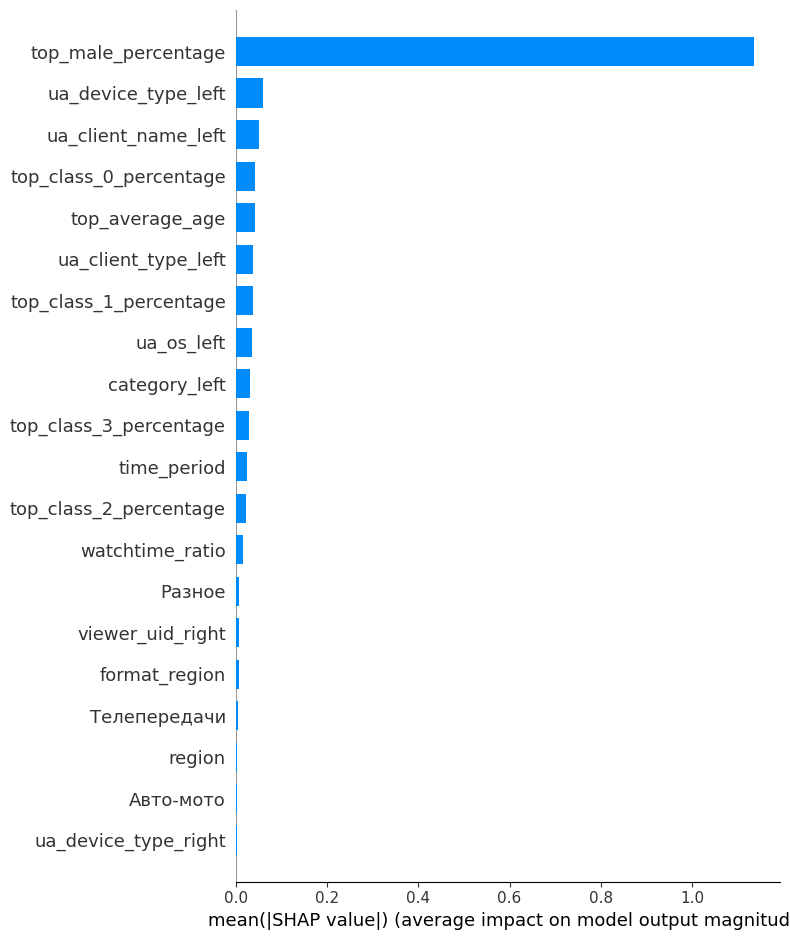

In [154]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test_sex)
shap.summary_plot(shap_values, X_test_sex, plot_type="bar")

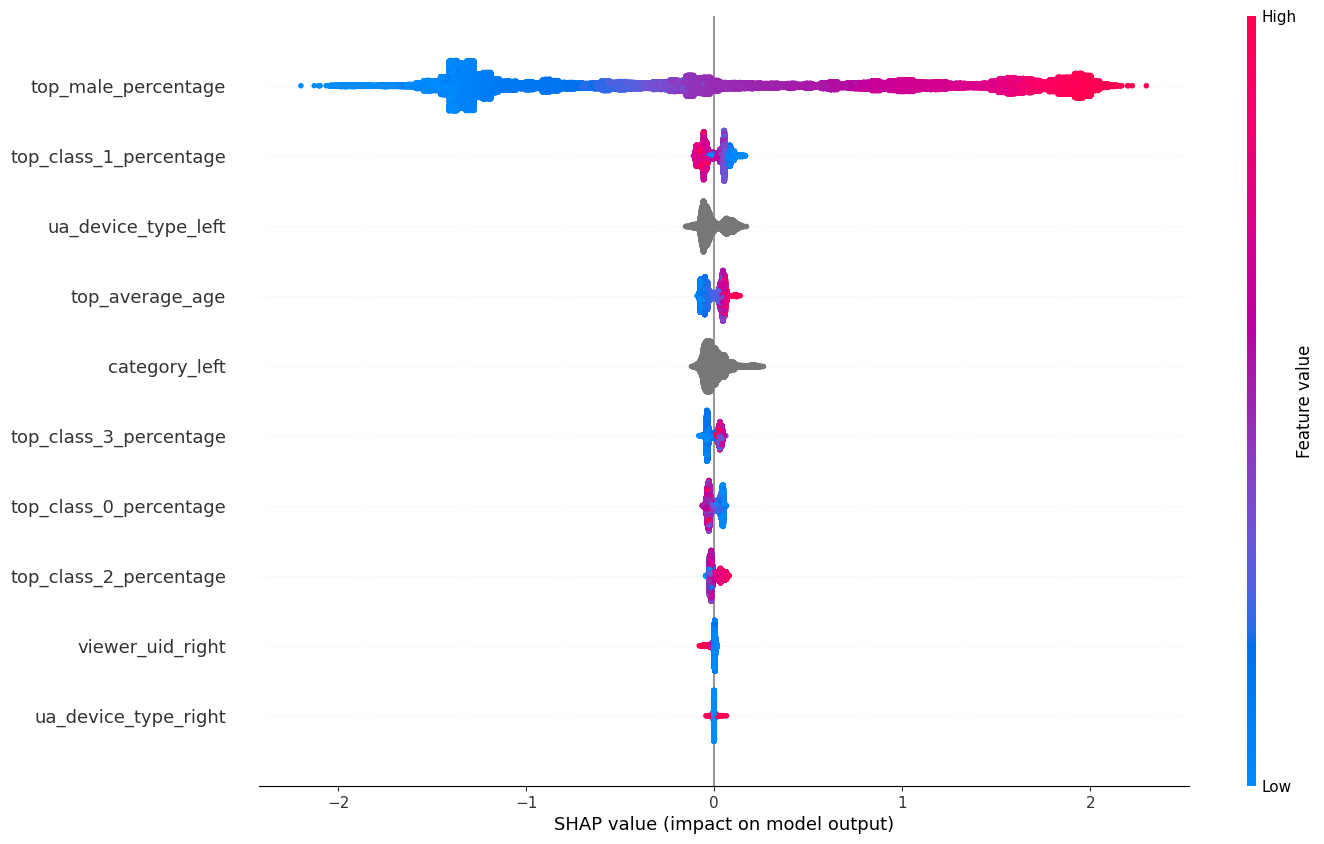

In [64]:
explainer = shap.TreeExplainer(best_model)
shap_obj = explainer(X_test_sex)
shap.plots.beeswarm(shap_obj[:,:10], max_display = 10, plot_size = (15, 10))

In [454]:
test['average_expenses'] = test['average_expenses'].fillna(test['average_expenses'].median())

In [455]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
test.drop('author_id', axis=1, inplace=True)

In [269]:
X_train_sex

,top_average_age,top_male_percentage,top_class_0_percentage,top_class_1_percentage,top_class_2_percentage,top_class_3_percentage,category_left,ua_device_type_left,ua_device_type_right,ua_client_type_left,ua_client_type_right,ua_os_left,ua_os_right,ua_client_name_left,region,format_region,weekday,time_period,mobile_net_speed,desktop_net_speed,watchtime_ratio,Телепередачи,Сериалы,Фильмы,Разное,Обучение,Развлечения,Интервью,Юмор,Видеоигры,Лайфстайл,Музыка,Спорт,Еда,Детям,Аниме,Мультфильмы,Технологии и интернет,Наука,Эзотерика,Путешествия,Красота,Авто-мото,Здоровье,Бизнес и предпринимательство,Культура,Хобби,Аудио,Сад и огород,Техника и оборудование,Психология,Обзоры и распаковки товаров,Аудиокниги,Строительство и ремонт,Лайфхаки,Природа,Люди и блоги,Животные,Охота и рыбалка,Недвижимость,Дизайн,women_men_ratio,average_expenses
26942,30.426,69.296000,4.188,46.718,44.338000,4.756000,Видеоигры,smartphone,1,browser,1,Android,1,Chrome Mobile,Moscow,Москва,3,afternoon,26.800000,82.600000,0.172849,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.15,43235.0
101319,30.600,69.580000,3.820,45.380,46.080000,4.720000,Еда,smartphone,1,browser,1,Android,1,Chrome Mobile,Moscow,Москва,6,night,31.000000,93.000000,0.210359,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.15,43235.0
10815,32.552,22.988000,2.728,39.530,42.838000,14.904000,Телепередачи,tablet,1,mobile app,1,Android,1,Rutube,Moscow,Москва,3,morning,28.625000,86.187500,0.187920,1,1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1.15,43235.0
98159,29.720,6.680000,3.930,54.220,34.770000,7.070000,Сериалы,desktop,1,browser,1,Windows,1,Microsoft Edge,Moscow,Москва,6,day,31.000000,93.000000,0.909192,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.15,43235.0
64699,37.790,52.320000,2.870,21.630,34.770000,40.730000,Развлечения,tablet,1,browser,1,Android,1,Firefox Mobile,St.-Petersburg,Санкт-Петербург,5,morning,25.000000,88.000000,3.171776,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.21,33588.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71060,28.330,100.000000,0.000,66.670,33.330000,0.000000,Сериалы,desktop,1,browser,1,Windows,1,Chrome,Nizhny Novgorod Oblast,Нижегородская область,0,day,21.000000,77.000000,0.804200,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.20,26487.0
17010,29.410,55.186667,0.000,58.970,36.963333,4.066667,Красота,smartphone,1,browser,1,IOS,1,Chrome Mobile iOS,Moscow,Москва,2,afternoon,31.000000,93.000000,0.428895,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.15,43235.0
77235,32.290,21.368000,2.178,41.560,42.930000,13.332000,Телепередачи,tablet,1,mobile app,1,Android,1,Rutube,Moscow,Москва,3,morning,31.105263,91.315789,0.727183,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.15,43235.0
49081,38.610,49.765000,2.190,21.070,32.580000,44.155000,Развлечения,smartphone,1,browser,1,Android,1,Firefox Mobile,Moscow,Москва,2,afternoon,31.000000,93.000000,1.744652,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1.15,43235.0


In [467]:
pres_res_sex = best_model.predict(test)

### STACK_SEX

In [65]:
# k = 5  # Количество фолдов
# kf = KFold(n_splits=k, shuffle=True, random_state=42)

# models = []  # Список для хранения обученных моделей
# predictions = np.zeros((len(y), 2))  # Для хранения вероятностей классов

# for train_index, val_index in kf.split(X_train_sex):
#     X_train, X_val = X_train_sex.iloc[train_index], X_train_sex.iloc[val_index]
#     y_train, y_val = y_train_sex.iloc[train_index], y_train_sex.iloc[val_index]

#     model = CatBoostClassifier(**best_params)
#     model.fit(X_train, y_train)

#     models.append(model)

#     # Получаем вероятности классов для валидационной выборки
#     pred_probs = model.predict_proba(X_test_sex)
#     predictions += pred_probs  # Суммируем вероятности

# # Получаем итоговые вероятности классов
# predictions /= k  # Мягкое голосование: усреднение вероятностей

# # Определяем финальные предсказания (выбор класса с наибольшей вероятностью)
# y_pred = np.argmax(predictions, axis=1)

In [272]:
print('accuracy test ', accuracy_score(y_test_sex, y_pred))
print('recall test ', recall_score(y_test_sex, y_pred, average="binary", pos_label="male"))
print('precision test ', precision_score(y_test_sex, y_pred, average="binary", pos_label="male"))
print('roc auc test ', roc_auc_score(y_test_sex, best_model.predict_proba(X_test_sex)[:, 1]))
print('f1 test ', f1_score(y_test_sex, y_pred, pos_label="male"))

accuracy test  0.7785462322584229
recall test  0.7683909976486396
precision test  0.7815614144980354
roc auc test  0.8633446307091545
f1 test  0.7749202495553736


## age

In [468]:
b = 0
best_params = {
    'iterations': 2000,
     'depth': 4,
     'learning_rate': 0.00628816,
     'l2_leaf_reg': 0.000211919,
     'random_strength': 9.991,
     'border_count': 113,
     'loss_function': 'MultiClass',
     'verbose': 1,
     'cat_features': cat.tolist(),
}
if use_optuna:
    b = study.best_params
    print("Best hyperparameters: ", study.best_params)
    print("Best f1: ", study.best_value)
else:
    print("без перебора")

без перебора


In [469]:
best_model = None
if use_optuna:
    best_model = CatBoostClassifier(**study.best_params)
else:
    best_model = CatBoostClassifier(**best_params)
best_model.fit(X_train_age, y_train_age)

0:	learn: 1.3827851	total: 89.9ms	remaining: 2m 59s
1:	learn: 1.3794074	total: 183ms	remaining: 3m 2s
2:	learn: 1.3760380	total: 260ms	remaining: 2m 53s
3:	learn: 1.3728353	total: 314ms	remaining: 2m 36s
4:	learn: 1.3695973	total: 367ms	remaining: 2m 26s
5:	learn: 1.3665975	total: 420ms	remaining: 2m 19s
6:	learn: 1.3638268	total: 499ms	remaining: 2m 22s
7:	learn: 1.3611422	total: 538ms	remaining: 2m 13s
8:	learn: 1.3579250	total: 602ms	remaining: 2m 13s
9:	learn: 1.3552777	total: 654ms	remaining: 2m 10s
10:	learn: 1.3526554	total: 688ms	remaining: 2m 4s
11:	learn: 1.3496269	total: 769ms	remaining: 2m 7s
12:	learn: 1.3468086	total: 858ms	remaining: 2m 11s
13:	learn: 1.3434779	total: 937ms	remaining: 2m 12s
14:	learn: 1.3410193	total: 970ms	remaining: 2m 8s
15:	learn: 1.3379828	total: 1.04s	remaining: 2m 9s
16:	learn: 1.3356103	total: 1.13s	remaining: 2m 11s
17:	learn: 1.3331185	total: 1.21s	remaining: 2m 13s
18:	learn: 1.3306482	total: 1.29s	remaining: 2m 15s
19:	learn: 1.3278212	total

In [275]:
y_pred = best_model.predict(X_test_age)

In [276]:
print('accuracy test ', accuracy_score(y_test_age, y_pred))
print('f1 test ', f1_score(y_test_age, y_pred, average='weighted'))

accuracy test  0.5336777490764658
f1 test  0.5250120025080113


In [277]:
p = pd.DataFrame(y_pred == y_test_age.reset_index(drop=True).values.reshape(-1, 1), columns=['percent of true'])
pd.concat([y_test_age.reset_index(drop=True), p], axis=1).groupby('age_class').mean()

,percent of true
age_class,
0,0.132853
1,0.670463
2,0.456305
3,0.523485


In [470]:
pres_res_age = best_model.predict(test)

In [471]:
res = pd.concat([ids, pd.DataFrame(np.arange(60004), columns=['age'])], axis=1)

In [472]:
res

,viewer_uid,age
0,22206,0
1,34531,1
2,25830,2
3,14838,3
4,13718,4
...,...,...
59999,57775,59999
60000,26104,60000
60001,30535,60001
60002,37268,60002


In [284]:
# res['viewer_uid'].unique()

KeyError: 'viewer_uid'

In [473]:
res = pd.concat([res, pd.DataFrame(pres_res_sex, columns=['sex'])], axis=1)

In [474]:
res = pd.concat([res, pd.DataFrame(pres_res_age, columns=['age_class'])], axis=1)

In [477]:
res.to_csv('submit.csv', index=False)

In [476]:
res

,viewer_uid,age,sex,age_class
0,22206,0,female,1
1,34531,1,male,2
2,25830,2,male,2
3,14838,3,female,1
4,13718,4,female,1
...,...,...,...,...
59999,57775,59999,male,2
60000,26104,60000,male,2
60001,30535,60001,male,3
60002,37268,60002,male,2
